グラフ

ノード: 各通貨（USD, EUR, JPY）や経済指標（GDP, インフレ率、失業率）をノードとする。

エッジ: 通貨間（為替レートの相関性や取引量）や通貨と経済指標間の関係性を初期的な隣接行列 𝐴として設定。
- 初期値は事前知識や過去データ（例えば、相関係数）を用いる。
- A は固定せず、GATが学習を通じてエッジ重みを動的に調整。

ノード特徴量

通貨ノード: 現在の価格変動率、移動平均、出来高、ボラティリティなど。

経済指標ノード: 最新のGDP成長率、CPI、金利、貿易収支など。

## Data Preparation

In [10]:
symbols = ["EURUSD", "USDJPY", "EURJPY"]

In [11]:
import glob
files = []

for symbol in symbols:
    files.extend(glob.glob(f'../../../Data/HistData/{symbol}*.csv'))

In [98]:
files

['../../../Data/HistData\\EURUSD_2000-2022_M1.csv',
 '../../../Data/HistData\\USDJPY_2000-2022_M1.csv',
 '../../../Data/HistData\\EURJPY_2002-2022_M1.csv']

In [99]:
import pandas as pd

df = None

for file in files:
    temp_df = pd.read_csv(file, index_col=0, parse_dates=True, names=["open", "high", "low", "close", "volume"], header=0)
    temp_df = temp_df[~temp_df.index.duplicated(keep='first')]
    resampler = temp_df["close"].resample("1D")
    close_srs = resampler.last()

    if df is None:
        df = close_srs
    else:
        df = pd.concat([df, close_srs], axis=1).dropna()

del temp_df, close_srs, resampler

In [8]:
df.columns = symbols
df.head()

,EURUSD,USDJPY,EURJPY
2002-03-03,0.8656,133.04,115.15
2002-03-04,0.8700,132.37,115.14
2002-03-05,0.8705,132.11,115.02
2002-03-06,0.8780,130.01,114.13
2002-03-10,0.8749,129.14,112.95


In [ ]:
# multi_index = pd.MultiIndex.from_product(
#     [symbols, ['open', 'high', 'low', 'close', 'volume']],
#     names=["symbol", "attribute"])
# df.columns = multi_index
# df.head()

In [32]:
pct_df = df.pct_change().dropna()
pct_df.head()

,EURUSD,USDJPY,EURJPY
2002-03-04,0.005083,-0.005036,-0.000087
2002-03-05,0.000575,-0.001964,-0.001042
2002-03-06,0.008616,-0.015896,-0.007738
2002-03-10,-0.003531,-0.006692,-0.010339
2002-03-11,0.000000,-0.002788,-0.002656


In [43]:
reverse_pct_df = (1/df).pct_change().dropna()
reverse_pct_df.columns = ["USDEUR", "JPYUSD", "JPYEUR"]
symbols.extend(["USDEUR", "JPYUSD", "JPYEUR"])
reverse_pct_df.head()

,USDEUR,JPYUSD,JPYEUR
2002-03-04,-0.005057,0.005062,0.000087
2002-03-05,-0.000574,0.001968,0.001043
2002-03-06,-0.008542,0.016153,0.007798
2002-03-10,0.003543,0.006737,0.010447
2002-03-11,0.000000,0.002795,0.002663


In [ ]:
pct_df = pd.concat([pct_df, reverse_pct_df], axis=1)
stat_df = pct_df.describe()
stat_df

,EURUSD,USDJPY,EURJPY,USDEUR,JPYUSD,JPYEUR
count,6464.000000,6464.000000,6464.000000,6464.000000,6464.000000,6464.000000
mean,0.000047,0.000013,0.000051,-0.000019,0.000017,-0.000010
std,0.005322,0.005441,0.006360,0.005321,0.005441,0.006367
min,-0.032913,-0.036678,-0.068424,-0.038990,-0.042682,-0.056996
25%,-0.002782,-0.002671,-0.002959,-0.002935,-0.002762,-0.003186
50%,0.000000,0.000105,0.000212,0.000000,-0.000105,-0.000212
75%,0.002943,0.002770,0.003196,0.002790,0.002678,0.002968
max,0.040572,0.044585,0.060441,0.034033,0.038075,0.073449


In [46]:
symbols = pct_df.columns
apprx_max = pct_df.quantile(0.9999)
token_df = (pct_df - stat_df.loc["min"]) / (apprx_max - stat_df.loc["min"])
multi_index = pd.MultiIndex.from_product(
    [symbols, ['mean']],
    names=["symbol", "attribute"])
token_df.columns = multi_index
token_df.head()

symbol,EURUSD,USDJPY,EURJPY,USDEUR,JPYUSD,JPYEUR
attribute,mean,mean,mean,mean,mean,mean
2002-03-04,0.555011,0.392851,0.545652,0.473400,0.605984,0.493806
2002-03-05,0.489156,0.430990,0.538024,0.535944,0.566719,0.502080
2002-03-06,0.606610,0.258024,0.484562,0.424785,0.746756,0.560514
2002-03-10,0.429187,0.372295,0.463791,0.593389,0.627247,0.583429
2002-03-11,0.480761,0.420766,0.525138,0.543957,0.577221,0.516092


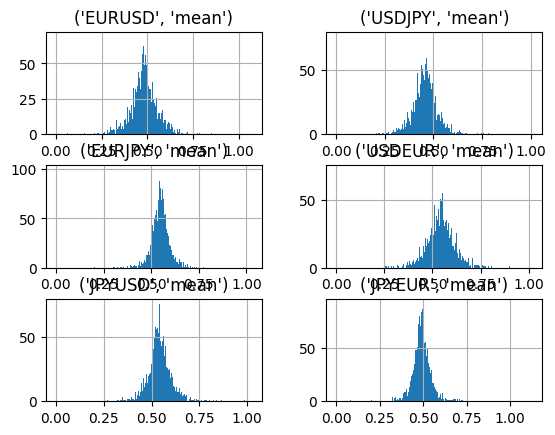

In [45]:
_ = token_df.hist(bins=1000)

In [52]:
ratio_df = df.iloc[:-7] / df.iloc[7:].values
ratio_df.head()

,EURUSD,USDJPY,EURJPY
2002-03-03,0.986551,1.032759,1.019117
2002-03-04,0.988524,1.018466,1.006557
2002-03-05,0.985732,1.006936,0.992750
2002-03-06,0.996143,0.983360,0.979320
2002-03-10,0.988141,0.982427,0.970694


In [53]:
reverse_ratio_df = (1/df).iloc[:-7] / (1/df).iloc[7:].values
reverse_ratio_df.columns = ["USDEUR", "JPYUSD", "JPYEUR"]
reverse_ratio_df.head()

,USDEUR,JPYUSD,JPYEUR
2002-03-03,1.013632,0.968280,0.981242
2002-03-04,1.011609,0.981869,0.993486
2002-03-05,1.014474,0.993112,1.007303
2002-03-06,1.003872,1.016922,1.021116
2002-03-10,1.012001,1.017888,1.030190


In [54]:
ratio_df = pd.concat([ratio_df, reverse_ratio_df], axis=1)
ratio_df.head()

,EURUSD,USDJPY,EURJPY,USDEUR,JPYUSD,JPYEUR
2002-03-03,0.986551,1.032759,1.019117,1.013632,0.968280,0.981242
2002-03-04,0.988524,1.018466,1.006557,1.011609,0.981869,0.993486
2002-03-05,0.985732,1.006936,0.992750,1.014474,0.993112,1.007303
2002-03-06,0.996143,0.983360,0.979320,1.003872,1.016922,1.021116
2002-03-10,0.988141,0.982427,0.970694,1.012001,1.017888,1.030190


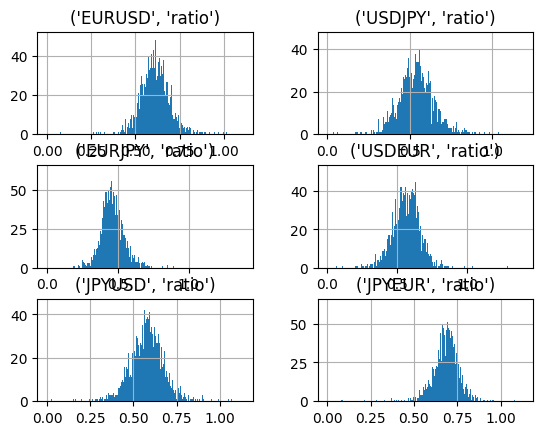

In [55]:
symbols
ratio_apprx_max = ratio_df.quantile(0.999)
ratio_min_srs = ratio_df.min()
ratio_token_df = (ratio_df - ratio_min_srs) / (ratio_apprx_max - ratio_min_srs)
multi_index = pd.MultiIndex.from_product(
    [symbols, ['ratio']],
    names=["symbol", "attribute"])
ratio_token_df.columns = multi_index
_ = ratio_token_df.hist(bins=1000)

In [58]:
symbol_features = pd.concat([token_df, ratio_token_df], axis=1).dropna()
symbol_features.head()

symbol,EURUSD,USDJPY,EURJPY,USDEUR,JPYUSD,JPYEUR,EURUSD,USDJPY,EURJPY,USDEUR,JPYUSD,JPYEUR
attribute,mean,mean,mean,mean,mean,mean,ratio,ratio,ratio,ratio,ratio,ratio
2002-03-04,0.555011,0.392851,0.545652,0.473400,0.605984,0.493806,0.545526,0.680356,0.499271,0.646193,0.442969,0.655229
2002-03-05,0.489156,0.430990,0.538024,0.535944,0.566719,0.502080,0.528747,0.592706,0.426780,0.667322,0.525050,0.718835
2002-03-06,0.606610,0.258024,0.484562,0.424785,0.746756,0.560514,0.591310,0.413480,0.356269,0.589141,0.698882,0.782424
2002-03-10,0.429187,0.372295,0.463791,0.593389,0.627247,0.583429,0.543224,0.406387,0.310978,0.649085,0.705933,0.824197
2002-03-11,0.480761,0.420766,0.525138,0.543957,0.577221,0.516092,0.604891,0.310412,0.298315,0.572385,0.802674,0.836010


In [60]:
symbol_features.to_csv("./symbol_features.csv")

In [66]:
commodity_symbols = ["oil", "gold"]
commodity_files = []
for symbol in commodity_symbols:
    commodity_files.extend(glob.glob(f'../../../Data/indicater/*{symbol}*.csv'))
commodity_files

['../../../Data/indicater\\crude-oil_USD_1990_2024.csv',
 '../../../Data/indicater\\gold_USD_Futures_1990_2024.csv']

In [100]:
com_df = pd.read_csv(commodity_files[0],index_col=0, parse_dates=True, names=["close", "open", "high", "low", "volume", "pct"], header=0)
com_df.head()

,close,open,high,low,volume,pct
2024-12-18,70.36,69.77,70.43,69.62,16.81K,0.40%
2024-12-17,70.08,70.61,70.92,69.18,99.60K,-0.89%
2024-12-16,70.71,71.44,71.44,70.37,204.30K,-0.81%
2024-12-13,71.29,70.06,71.42,69.87,230.43K,1.81%
2024-12-12,70.02,70.43,70.72,69.14,326.05K,-0.38%


In [129]:
import pandas as pd

com_df = None

for file in commodity_files:
    temp_df = pd.read_csv(file, index_col=0, parse_dates=True, names=["close", "open", "high", "low", "volume", "pct"], header=0)
    close_srs = temp_df["close"]
    if close_srs.dtype == pd.StringDtype:
        close_srs = close_srs.str.replace(",", "").astype(float)

    if com_df is None:
        com_df = close_srs
    else:
        com_df = pd.concat([com_df, close_srs], axis=1).dropna()

com_df.columns = commodity_symbols
del temp_df, close_srs

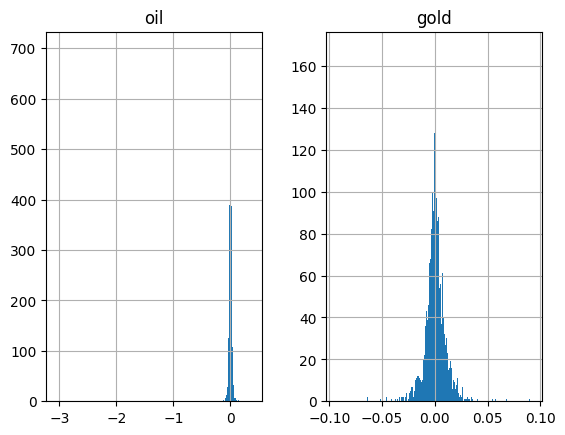

In [132]:
pct_df = com_df.pct_change()
_ = pct_df.hist(bins=1000)

In [135]:
df.columns = symbols
df.head()

,EURUSD,USDJPY,EURJPY
2002-03-03,0.8656,133.04,115.15
2002-03-04,0.8700,132.37,115.14
2002-03-05,0.8705,132.11,115.02
2002-03-06,0.8780,130.01,114.13
2002-03-10,0.8749,129.14,112.95


In [143]:
com_df = pd.concat([df, com_df], axis=1).dropna()
com_df.head()

,EURUSD,USDJPY,EURJPY,oil,gold
2002-03-04,0.8700,132.37,115.14,22.45,297.1
2002-03-05,0.8705,132.11,115.02,23.17,294.4
2002-03-06,0.8780,130.01,114.13,23.15,293.9
2002-03-11,0.8749,128.78,112.65,24.31,291.3
2002-03-12,0.8746,129.32,113.07,24.20,293.8


In [163]:
EUR_com_df = com_df[commodity_symbols].mul((1/com_df["EURUSD"]), axis=0)
EUR_com_df.head()

,oil,gold
2002-03-04,25.804598,341.494253
2002-03-05,26.616887,338.196439
2002-03-06,26.366743,334.738041
2002-03-11,27.786033,332.952337
2002-03-12,27.669792,335.924994


In [166]:
JPY_com_df = com_df[commodity_symbols].mul((com_df["USDJPY"]), axis=0)
JPY_com_df.head()

,oil,gold
2002-03-04,2971.7065,39327.127
2002-03-05,3060.9887,38893.184
2002-03-06,3009.7315,38209.939
2002-03-11,3130.6418,37513.614
2002-03-12,3129.5440,37994.216


In [170]:
com_df = com_df[commodity_symbols]
com_df = pd.concat([com_df, EUR_com_df, JPY_com_df], axis=1)
multi_index = pd.MultiIndex.from_product(
    [["USD", "EUR", "JPY"], commodity_symbols],
    names=["symbol", "attribute"])
com_df.columns = multi_index
com_df.head()

symbol        USD               EUR                    JPY           
attribute     oil   gold        oil        gold        oil       gold
2002-03-04  22.45  297.1  25.804598  341.494253  2971.7065  39327.127
2002-03-05  23.17  294.4  26.616887  338.196439  3060.9887  38893.184
2002-03-06  23.15  293.9  26.366743  334.738041  3009.7315  38209.939
2002-03-11  24.31  291.3  27.786033  332.952337  3130.6418  37513.614
2002-03-12  24.20  293.8  27.669792  335.924994  3129.5440  37994.216

In [171]:
com_df.to_csv("./commodity_features.csv")

In [260]:
com_token_df = com_df.pct_change().dropna()
com_token_df.columns = com_token_df.columns.swaplevel(0, 1)
com_stat_df = com_token_df.describe()
com_stat_df

attribute,oil,gold,oil,gold,oil,gold
symbol,USD,USD,EUR,EUR,JPY,JPY
count,5206.000000,5206.000000,5206.000000,5206.000000,5206.000000,5206.000000
mean,0.997917,0.895426,0.997976,0.898430,0.997834,0.906781
std,0.004060,0.093392,0.004035,0.093883,0.004101,0.087521
min,0.763821,0.114870,0.764781,0.113479,0.763663,0.126031
25%,0.996985,0.851512,0.997069,0.851901,0.996832,0.864188
50%,0.998010,0.896076,0.998063,0.899560,0.997943,0.908245
75%,0.998952,0.944953,0.998980,0.946950,0.998915,0.953662
max,1.026743,1.637833,1.027037,1.542000,1.026720,1.515765


In [293]:
apprx_min_oil = com_token_df["oil"].quantile(0.005)
min_oil = com_stat_df["oil"].loc["min"]
apprx_max_oil = com_token_df["oil"].quantile(0.995)
max_oil = com_stat_df["oil"].loc["max"]

oil_token_df = (com_token_df["oil"] - apprx_min_oil) / (apprx_max_oil - apprx_min_oil)
oil_token_df.head()

symbol,USD,EUR,JPY
2002-03-05,0.674975,0.675344,0.643035
2002-03-06,0.490410,0.438311,0.396714
2002-03-11,0.776053,0.804948,0.696358
2002-03-12,0.469890,0.468549,0.483023
2002-03-13,0.485985,0.464748,0.455847


C:\Users\ksato\AppData\Local\Temp\ipykernel_21024\404953775.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


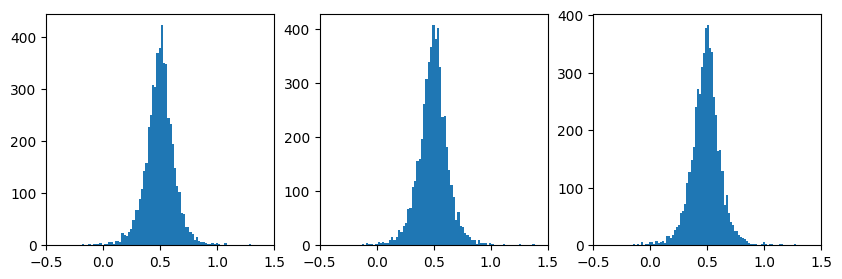

In [294]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3, figsize=(10, 3))
for i, column in enumerate(oil_token_df.columns):
    axs[i].hist(oil_token_df[column], bins=1000)
    axs[i].set_xlim(-0.5, 1.5)
fig.show()

In [295]:
max_gold = com_stat_df["gold"].loc["max"]
apprx_max_gold = com_token_df["gold"].quantile(0.99)
apprx_min_gold = com_token_df["gold"].quantile(0.01)

gold_token_df = (com_token_df["gold"] - apprx_min_gold) / (apprx_max_gold - apprx_min_gold)
gold_token_df.head()

symbol,USD,EUR,JPY
2002-03-05,0.371422,0.338000,0.344602
2002-03-06,0.494659,0.328432,0.239829
2002-03-11,0.375446,0.410677,0.229302
2002-03-12,0.666112,0.650496,0.727022
2002-03-13,0.522983,0.446717,0.459554


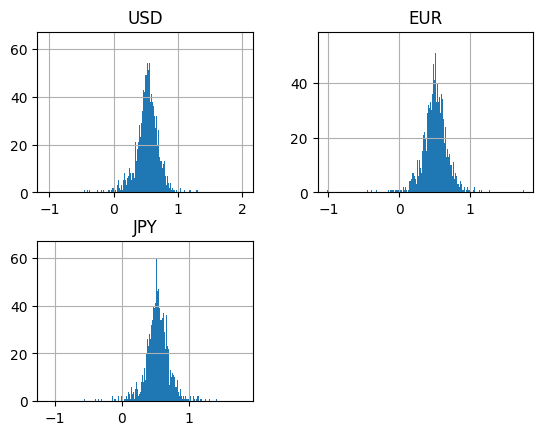

In [296]:
_ = gold_token_df.hist(bins=1000)

In [309]:
com_token_df = pd.concat([oil_token_df, gold_token_df], axis=1)
multi_index = pd.MultiIndex.from_product(
    [commodity_symbols, ["USD", "EUR", "JPY"]],
    names=["attribute", "symbol"])
com_token_df.columns = multi_index.swaplevel(0, 1)
com_token_df = com_token_df[["USD", "EUR", "JPY"]]
com_token_df.head()

symbol           USD                 EUR                 JPY          
attribute        oil      gold       oil      gold       oil      gold
2002-03-05  0.674975  0.371422  0.675344  0.338000  0.643035  0.344602
2002-03-06  0.490410  0.494659  0.438311  0.328432  0.396714  0.239829
2002-03-11  0.776053  0.375446  0.804948  0.410677  0.696358  0.229302
2002-03-12  0.469890  0.666112  0.468549  0.650496  0.483023  0.727022
2002-03-13  0.485985  0.522983  0.464748  0.446717  0.455847  0.459554

In [310]:
com_token_df.to_csv("./commodity_features_token.csv")

In [12]:
additional_feature_symbol_dict = {
    "USD": ["US-10-year-bond-yield", "NY_daw"],
    "EUR": ["germany-10-year-bond",  "dax_price"],
    "JPY": ["japan-10-year-bond", "japan-ni225"]
}
additional_feature_symbols = ["bond", "stock"]
additional_feature_files = []

for symbol_key_list in additional_feature_symbol_dict.values():
    for symbol_key in symbol_key_list:
         additional_feature_files.extend(glob.glob(f'../../../Data/indicater/*{symbol_key}*.csv'))
additional_feature_files

['../../../Data/indicater\\US-10-year-bond-yield_2008_2024.csv',
 '../../../Data/indicater\\NY_daw_mean_2008_2024.csv',
 '../../../Data/indicater\\germany-10-year-bond-yield-historical-data_1990_2024.csv',
 '../../../Data/indicater\\dax_price_1990_2024.csv',
 '../../../Data/indicater\\japan-10-year-bond-yield_2000_2024.csv',
 '../../../Data/indicater\\japan-ni225_2008_2024.csv']

In [13]:
import pandas as pd

feature_df = None

for file in additional_feature_files:
    temp_df = pd.read_csv(file, index_col=0, parse_dates=True, header=0)
    if len(temp_df.columns) == 5:
        temp_df.columns = ["close", "open", "high", "low", "pct"]
    else:
        temp_df.columns = ["close", "open", "high", "low", "volume", "pct"]
    temp_df = temp_df[~temp_df.index.duplicated(keep='first')]
    close_srs = temp_df["close"]
    if close_srs.dtype == pd.StringDtype:
        close_srs = close_srs.str.replace(",", "").astype(float)

    if feature_df is None:
        feature_df = close_srs
    else:
        feature_df = pd.concat([feature_df, close_srs], axis=1).dropna()

multi_index = pd.MultiIndex.from_product(
    [["USD", "EUR", "JPY"], additional_feature_symbols],
    names=["symbol", "attribute"])
feature_df.columns = multi_index
feature_df.index.name = "date"
del temp_df, close_srs

In [14]:
feature_df.head()

symbol        USD              EUR             JPY          
attribute    bond     stock   bond    stock   bond     stock
date                                                        
2006-02-07  4.571  10749.76  3.465  3892.92  1.586  16720.99
2006-02-08  4.591  10858.62  3.491  3888.47  1.576  16272.68
2006-02-09  4.549  10883.35  3.493  3941.47  1.567  16439.67
2006-02-10  4.590  10919.05  3.454  3912.63  1.604  16257.83
2006-02-13  4.585  10892.32  3.491  3950.22  1.567  15877.66

<Axes: xlabel='date'>

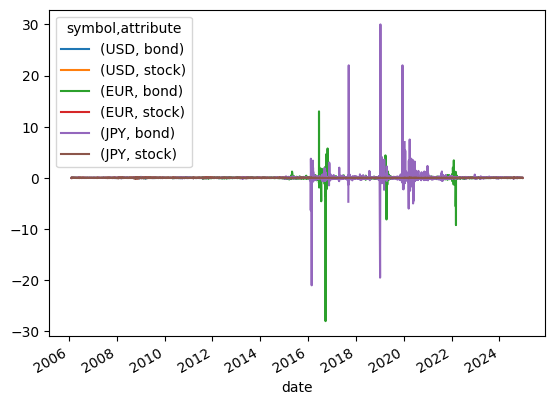

In [319]:
pct_df = feature_df.pct_change().dropna()
pct_df.plot()

In [327]:
feature_df[feature_df == 0].dropna(how="all")

symbol      USD        EUR        JPY      
attribute  bond stock bond stock bond stock
date                                       
2017-09-01  NaN   NaN  NaN   NaN  0.0   NaN
2019-01-25  NaN   NaN  NaN   NaN  0.0   NaN
2019-01-28  NaN   NaN  NaN   NaN  0.0   NaN
2019-01-31  NaN   NaN  NaN   NaN  0.0   NaN
2020-01-09  NaN   NaN  NaN   NaN  0.0   NaN
2020-01-17  NaN   NaN  NaN   NaN  0.0   NaN

In [15]:
feature_df.columns = feature_df.columns.swaplevel(0,1)
stock_token_df = feature_df["stock"].pct_change().dropna()
stock_token_df.head()

symbol,USD,EUR,JPY
date,,,
2006-02-08,0.010127,-0.001143,-0.026811
2006-02-09,0.002277,0.013630,0.010262
2006-02-10,0.003280,-0.007317,-0.011061
2006-02-13,-0.002448,0.009607,-0.023384
2006-02-14,0.012492,0.001235,0.019349


In [16]:
stock_token_stat = stock_token_df.describe()
stock_token_stat

symbol,USD,EUR,JPY
count,4427.000000,4427.000000,4427.000000
mean,0.000388,0.000252,0.000306
std,0.011981,0.013816,0.014968
min,-0.129265,-0.122397,-0.123958
25%,-0.004142,-0.005901,-0.006844
50%,0.000585,0.000787,0.000684
75%,0.005637,0.006899,0.008073
max,0.113650,0.144108,0.141503


In [17]:
apprx_min_stock = stock_token_df.quantile(0.001)
min_stock = stock_token_stat.loc["min"]
apprx_max_stock = stock_token_df.quantile(0.995)
max_stock = stock_token_stat.loc["max"]

stock_token_std_df = (stock_token_df - apprx_min_stock) / (apprx_max_stock - apprx_min_stock)
stock_token_std_df.head()

symbol,USD,EUR,JPY
date,,,
2006-02-08,0.745967,0.599387,0.477320
2006-02-09,0.677916,0.727113,0.736692
2006-02-10,0.686610,0.546009,0.587512
2006-02-13,0.636948,0.692334,0.501299
2006-02-14,0.766476,0.619951,0.800263


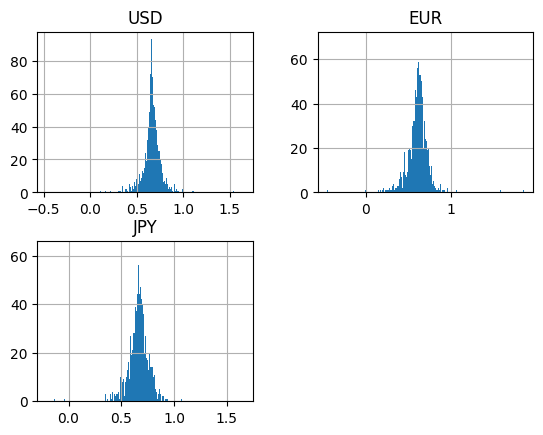

In [339]:
_ = stock_token_std_df.hist(bins=1000)

In [18]:
stock_token_std_df.to_csv("stock_pct_token.csv")

In [344]:
bond_diff_uj = feature_df["bond"]["USD"] - feature_df["bond"]["JPY"]
bond_diff_ue = feature_df["bond"]["USD"] - feature_df["bond"]["EUR"]
bond_diff_ej = feature_df["bond"]["EUR"] - feature_df["bond"]["JPY"]

<Axes: xlabel='date'>

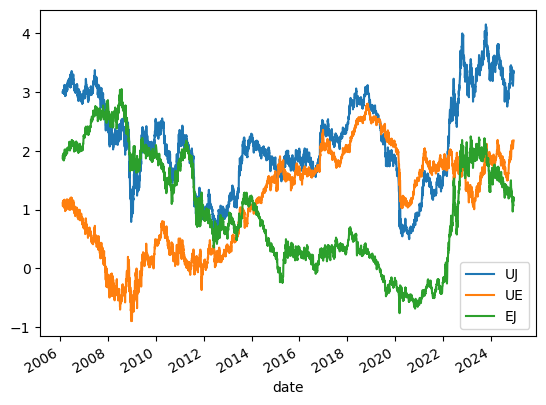

In [366]:
bond_symbol_diff_df = pd.concat([bond_diff_uj, bond_diff_ue, bond_diff_ej], keys=["UJ", "UE", "EJ"], axis=1)
bond_symbol_diff_df.plot()

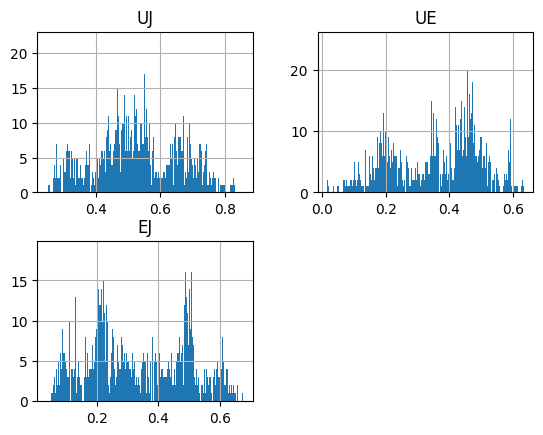

In [369]:
bond_symbol_diff_token_df = ((bond_symbol_diff_df +1)/6)
_ = bond_symbol_diff_token_df.hist(bins=1000)

In [371]:
bond_symbol_diff_token_df.to_csv("./bond_symbol_diff_token.csv")

<Axes: xlabel='date'>

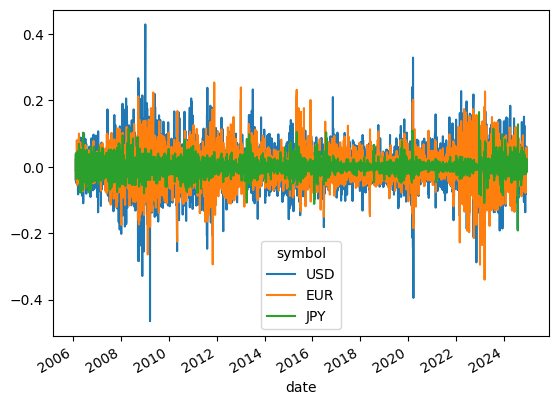

In [359]:
bond_diff_df = feature_df["bond"].diff().dropna()
bond_diff_df.plot()

In [361]:
bond_diff_stat = bond_diff_df.describe()
bond_diff_stat

symbol,USD,EUR,JPY
count,4427.000000,4427.000000,4427.000000
mean,-0.000038,-0.000279,-0.000115
std,0.061674,0.049232,0.020919
min,-0.465000,-0.340000,-0.192000
25%,-0.036000,-0.027000,-0.010000
50%,0.000000,-0.001000,0.000000
75%,0.036000,0.026000,0.009000
max,0.429000,0.254000,0.165000


In [362]:
apprx_min_bond = bond_diff_df.quantile(0.001)
min_bond = bond_diff_stat.loc["min"]
apprx_max_bond = bond_diff_df.quantile(0.995)
max_bond = bond_diff_stat.loc["max"]

bond_token_std_df = (bond_diff_df - apprx_min_bond) / (apprx_max_bond - apprx_min_bond)
bond_token_std_df.head()

symbol,USD,EUR,JPY
date,,,
2006-02-08,0.642085,0.665904,0.469513
2006-02-09,0.510950,0.604102,0.475690
2006-02-10,0.686502,0.498522,0.759869
2006-02-13,0.589208,0.694231,0.302712
2006-02-14,0.656891,0.573200,0.735158


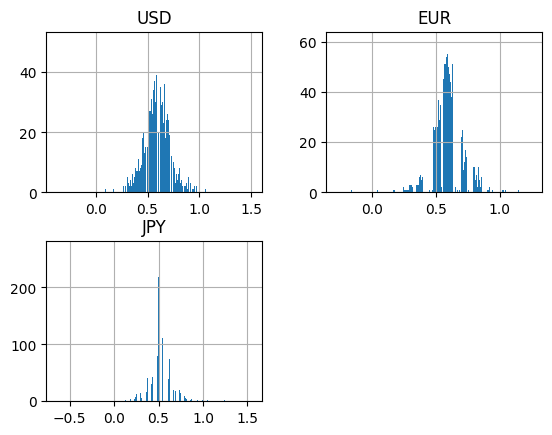

In [365]:
_ = bond_token_std_df.hist(bins=1000)

In [372]:
bond_token_std_df.to_csv("./bond_diff_token.csv")

## Feature Vector

In [52]:
import pandas as pd

symbol_df = pd.read_csv("symbol_features_token.csv", header=[0, 1], index_col=0)
com_df = pd.read_csv("commodity_features_token.csv", header=[0, 1], index_col=0)
bond_df = pd.read_csv("bond_diff_token.csv", header=0, index_col=0)
bond_sdiff_df = pd.read_csv("bond_symbol_diff_token.csv", header=0, index_col=0)
stock_df = pd.read_csv("stock_pct_token.csv", header=0, index_col=0)

In [72]:

import re

tokens = {
    "currency": symbol_df,
    # "commodity": com_df,
    # "bond": bond_df,
    # "stock": stock_df
}
token_columns = {}

for symbol in ["USD", "EUR", "JPY"]:
    pattern = rf"{symbol}.*"
    token_columns[symbol] = {}
    for key, df in tokens.items():
        symbol_columns = []
        for columns in df.columns:
            if isinstance(columns, tuple):
                # columns = (symbol, attribute)
                match = re.match(pattern, columns[0])
            else:
                # columns = symbol
                match = re.match(pattern, columns)
            if match:
                symbol_columns.append(columns)

        token_columns[symbol][key] = symbol_columns

In [74]:
usd_feature_df = None
for key, columns in token_columns["USD"].items():
    df = tokens[key][columns]
    if len(columns) == 1 and columns[0] == "USD":
        df.columns = [key]
    else:
        columns = ["_".join(column) for column in columns]
        df.columns = columns
    if usd_feature_df is None:
        usd_feature_df = df
    else:
        usd_feature_df = pd.concat([usd_feature_df, df], axis=1).dropna()

In [75]:
usd_feature_df.head()

,USDJPY_mean,USDEUR_mean,USDJPY_ratio,USDEUR_ratio
2002-03-04,0.392851,0.473400,0.680356,0.646193
2002-03-05,0.430990,0.535944,0.592706,0.667322
2002-03-06,0.258024,0.424785,0.413480,0.589141
2002-03-10,0.372295,0.593389,0.406387,0.649085
2002-03-11,0.420766,0.543957,0.310412,0.572385


In [81]:
feature_df = None

for symbol in ["USD", "EUR", "JPY"]:
    symbol_feature_df = None
    for key, columns in token_columns[symbol].items():
        df = tokens[key][columns]
        if len(columns) == 1 and columns[0] == symbol:
            df.columns = [key]
        else:
            columns = ["_".join(column) for column in columns]
            df.columns = columns
        if symbol_feature_df is None:
            symbol_feature_df = df
        else:
            symbol_feature_df = pd.concat([symbol_feature_df, df], axis=1).dropna()
    multi_index = pd.MultiIndex.from_product([[symbol], symbol_feature_df.columns], names=["symbol", "attribute"])
    symbol_feature_df.columns = multi_index
    if feature_df is None:
        feature_df = symbol_feature_df
    else:
        feature_df = pd.concat([feature_df, symbol_feature_df], axis=1)

In [82]:
feature_df.head()

symbol             USD                                               EUR  \
attribute  USDJPY_mean USDEUR_mean USDJPY_ratio USDEUR_ratio EURUSD_mean   
2002-03-04    0.392851    0.473400     0.680356     0.646193    0.555011   
2002-03-05    0.430990    0.535944     0.592706     0.667322    0.489156   
2002-03-06    0.258024    0.424785     0.413480     0.589141    0.606610   
2002-03-10    0.372295    0.593389     0.406387     0.649085    0.429187   
2002-03-11    0.420766    0.543957     0.310412     0.572385    0.480761   

symbol                                                   JPY              \
attribute  EURJPY_mean EURUSD_ratio EURJPY_ratio JPYUSD_mean JPYEUR_mean   
2002-03-04    0.545652     0.545526     0.499271    0.605984    0.493806   
2002-03-05    0.538024     0.528747     0.426780    0.566719    0.502080   
2002-03-06    0.484562     0.591310     0.356269    0.746756    0.560514   
2002-03-10    0.463791     0.543224     0.310978    0.627247    0.583429   
2002-03-11    0.525138     0.604891     0.298315    0.577221    0.516092   

symbol                                
attribute  JPYUSD_ratio JPYEUR_ratio  
2002-03-04     0.442969     0.655229  
2002-03-05     0.525050     0.718835  
2002-03-06     0.698882     0.782424  
2002-03-10     0.705933     0.824197  
2002-03-11     0.802674     0.836010

## Model Definition and Test it

In [214]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TimeSeriesGAT(nn.Module):
    def __init__(self, in_features, out_features, num_heads):
        super(TimeSeriesGAT, self).__init__()
        self.gat_layers = nn.ModuleList([
            nn.Linear(in_features, out_features) for _ in range(num_heads)
        ])
        self.attention_layers = nn.ModuleList([
            nn.Linear(2 * out_features, 1) for _ in range(num_heads)
        ])
        self.num_heads = num_heads

    def forward(self, X):
        # X shape: (num_nodes, length, in_features)
        num_nodes, length, in_features = X.shape
        adjacency_matrices = []  # To store A_t for each timestep
        
        for t in range(length):  # Process each time slice
            X_t = X[:, t, :]  # Shape: (num_nodes, in_features)
            head_adjacencies = []

            for head in range(self.num_heads):
                H = self.gat_layers[head](X_t)  # Shape: (num_nodes, out_features)
                H_repeat = H.unsqueeze(0).repeat(num_nodes, 1, 1)  # Shape: (num_nodes, num_nodes, out_features)
                H_concat = torch.cat([H_repeat, H_repeat.transpose(0, 1)], dim=-1)  # Shape: (num_nodes, num_nodes, 2*out_features)
                attention = F.leaky_relu(self.attention_layers[head](H_concat))  # Shape: (num_nodes, num_nodes, 1)
                attention = F.softmax(attention, dim=1).squeeze(-1)  # Shape: (num_nodes, num_nodes)
                head_adjacencies.append(attention)

            # Combine attention heads into a single adjacency matrix
            A_t = torch.mean(torch.stack(head_adjacencies, dim=0), dim=0)  # Shape: (num_nodes, num_nodes)
            adjacency_matrices.append(A_t)

        return torch.stack(adjacency_matrices, dim=0)  # Shape: (length, num_nodes, num_nodes)

In [215]:
class TimeSeriesGNN(nn.Module):
    def __init__(self, in_features, embedding_dim):
        super(TimeSeriesGNN, self).__init__()
        self.linear = nn.Linear(in_features, embedding_dim)

    def forward(self, A, X):
        # A shape: (length, num_nodes, num_nodes)
        # X shape: (length, num_nodes, in_features)
        length, num_nodes, _ = A.shape
        embeddings = []

        for t in range(length):
            A_t = A[t]  # Shape: (num_nodes, num_nodes)
            X_t = X[t]  # Shape: (num_nodes, in_features)
            H_t = F.relu(A_t @ self.linear(X_t))  # Shape: (num_nodes, embedding_dim)
            embeddings.append(H_t)

        return torch.stack(embeddings, dim=0)  # Shape: (length, num_nodes, embedding_dim)


In [236]:
class TimeSeriesPredictor(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(TimeSeriesPredictor, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, H):
        # H shape: (length, num_nodes, embedding_dim)
        length, num_nodes, embedding_dim = H.shape
        H_flat = H.permute(1, 0, 2)  # Shape: (num_nodes, length, embedding_dim)
        lstm_out, _ = self.lstm(H_flat)  # Shape: (num_nodes, length, hidden_dim)
        predictions = self.fc(lstm_out)  # Shape: (num_nodes, length, output_dim)
        return predictions.permute(1, 0, 2)  # Shape: (length, num_nodes, output_dim)

In [217]:
class TimeGraphModel(nn.Module):
    def __init__(self, in_features, out_features, num_heads, embedding_dim, hidden_dim, output_dim):
        super(TimeGraphModel, self).__init__()
        self.gat = TimeSeriesGAT(in_features, out_features, num_heads)
        self.gnn = TimeSeriesGNN(in_features, embedding_dim)
        self.predictor = TimeSeriesPredictor(embedding_dim, hidden_dim, output_dim)

    def forward(self, X):
        # X shape: (num_nodes, length, in_features)
        A = self.gat(X)  # Shape: (length, num_nodes, num_nodes)
        H = self.gnn(A, X.permute(1, 0, 2))  # Shape: (length, num_nodes, embedding_dim)
        predictions = self.predictor(H)  # Shape: (length, num_nodes, output_dim)   
        return predictions

In [188]:
# sample observation
feature_x = feature_df.iloc[0:10]
X_t = [feature_x[symbol].values.tolist() for symbol in ["USD", "EUR", "JPY"]]
X_t = torch.tensor(X_t)

In [189]:
num_nodes, _, feature_dim = X_t.shape

In [190]:
model = TimeGraphModel(in_features=feature_dim, out_features=2, embedding_dim=4, num_heads=4, hidden_dim=5, output_dim=1)
y = model(X_t)

In [191]:
y.shape

torch.Size([10, 3, 1])

## Training

In [263]:
import random
from collections.abc import Iterable

import numpy as np
import torch
from torch.utils.data import Dataset

class FeatureDataset(Dataset):

    def __init__(
        self,
        df,
        symbols: list,
        observation_length,
        device="cuda",
        seed=1017,
        is_training=True,
        randomize=True,
        split_ratio=0.9,
        dtype=torch.float,
        batch_size = None
    ):
        self.seed(seed)
        self.data = df
        self.dtype = dtype
        self.is_training = is_training
        self.device = device
        self._columns = symbols
        self.observation_length = observation_length
        self._split_ratio = split_ratio
        self.batch_size = batch_size
        self._init_indicies(randomize)

    def _init_indicies(self, randomize=True):
        train_data_length = int(len(self.data.index) * self._split_ratio)
        train_indices = list(range(self.observation_length, train_data_length))
        eval_indices = list(range(train_data_length + self.observation_length, len(self.data.index)))
        if randomize:
            train_indices = random.sample(train_indices, k=len(train_indices))
            eval_indices = random.sample(eval_indices, k=len(eval_indices))
        self.train_indices, self.eval_indices = train_indices, eval_indices

        if self.is_training:
            self._indices = self.train_indices
        else:
            self._indices = self.eval_indices
    
    def output_indices(self, index):
        # return slice(index - self.observation_length + 1, index + 1)
        return index

    def _output_func(self, batch_size):
        indices = self._indices[batch_size]
        if type(indices) == int:
            ndx = self.output_indices(indices)
            feature_y = self.data.iloc[ndx]
            y = [feature_y[symbol].values.tolist() for symbol in self._columns]
            ans = torch.tensor(y, device=self.device, dtype=self.dtype)
            return ans
        else:
            chunk_data = []
            for index in indices:
                ndx = self.output_indices(index)
                feature_y = self.data.iloc[ndx]
                y = [feature_y[symbol].values.tolist() for symbol in self._columns]
                chunk_data.append(y)
            ans = torch.tensor(chunk_data, device=self.device, dtype=self.dtype)
            return ans

    def input_indices(self, index):
        return slice(index - self.observation_length, index)

    def _input_func(self, batch_size):
        indices = self._indices[batch_size]
        if type(indices) == int:
            ndx = self.input_indices(indices)
            feature_x = self.data.iloc[ndx]
            x = [feature_x[symbol].values.tolist() for symbol in self._columns]
            src = torch.tensor(x, device=self.device, dtype=self.dtype)
            return src
        else:
            chunk_src = []
            for index in indices:
                ndx = self.input_indices(index)
                feature_x = self.data.iloc[ndx]
                x = [feature_x[symbol].values.tolist() for symbol in self._columns]
                chunk_src.append(x)

            src = torch.tensor(chunk_src, device=self.device, dtype=self.dtype)
            return src

    def __len__(self):
        return len(self._indices)

    def __getitem__(self, ndx):
        return self._input_func(ndx), self._output_func(ndx)
    
    def __iter__(self):
        self._init_indicies()
        self._index = 0
        if self.batch_size is None or self.batch_size == 1:
            self.batch_size = 1
            self._get_itr_ndx = lambda i: i
        else:
            self._get_itr_ndx = lambda i: slice(i, i + self.batch_size)
        return self
 
    def __next__(self):
        if self._index + self.batch_size >= len(self):
            raise StopIteration
        ndx = self._get_itr_ndx(self._index)
        self._index += self.batch_size
        return self._input_func(ndx), self._output_func(ndx)

    def seed(self, seed=None):
        """ """
        if seed is None:
            seed = 1017
        else:
            torch.backends.cudnn.benchmark = False
            torch.backends.cudnn.deterministic = True
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)
        self.seed_value = seed

    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)

    def render(self, mode="human", close=False):
        """ """
        pass

    def eval(self):
        self._indices = random.sample(self.eval_indices, k=len(self.eval_indices))
        self.is_training = False

    def train(self):
        self._indices = random.sample(self.train_indices, k=len(self.train_indices))
        self.is_training = True

    def get_index_range(self):
        return min(self._indices), max(self._indices)

    def get_date_range(self):
        min_index, max_index = self.get_index_range()
        return self.data.index[min_index], self.data.index[max_index]

    def get_actual_index(self, ndx):
        inputs = []
        if type(ndx) == slice:
            inputs = self._indices[ndx]
        elif isinstance(ndx, Iterable):
            for index in ndx:
                inputs.append(self._indices[index])
        else:
            return self._indices[ndx]

        return inputs

    def get_row_data(self, ndx):
        inputs = []
        if type(ndx) == slice:
            for index in self._indices[ndx]:
                df = self.data.iloc[index - self.observation_length : index]
                inputs.append(df)
        else:
            index = ndx
            inputs = df = self.data.iloc[index -self.observation_length: index]
        return inputs

In [264]:
ds = FeatureDataset(feature_df, symbols=["USD", "EUR", "JPY"], observation_length=10, device="cpu")

In [258]:
model = TimeGraphModel(in_features=feature_dim, out_features=2, embedding_dim=4, num_heads=4, hidden_dim=5, output_dim=feature_dim)

In [259]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [266]:
epochs = 10

for epoch in range(epochs):
    model.train()
    ds.train()
    epoch_loss = 0

    for X, Y in ds:
        outputs = model(X)  # Shape: (length, num_nodes, out_features)
        loss = criterion(outputs[-1], Y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss = epoch_loss / len(ds)
    
    model.eval()
    ds.eval()
    eval_loss = 0
    for X, Y in ds:
        outputs = model(X)  # Shape: (length, num_nodes, out_features)
        loss = criterion(outputs[-1], Y)
        eval_loss += loss.item()
    
    eval_loss = eval_loss / len(ds)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Eval Loss: {eval_loss:.4f}")

Epoch 1/10, Loss: 0.0055, Eval Loss: 0.0044
Epoch 2/10, Loss: 0.0054, Eval Loss: 0.0043
Epoch 3/10, Loss: 0.0054, Eval Loss: 0.0043
Epoch 4/10, Loss: 0.0054, Eval Loss: 0.0042
Epoch 5/10, Loss: 0.0053, Eval Loss: 0.0044
Epoch 6/10, Loss: 0.0053, Eval Loss: 0.0044
Epoch 7/10, Loss: 0.0053, Eval Loss: 0.0041
Epoch 8/10, Loss: 0.0053, Eval Loss: 0.0042
Epoch 9/10, Loss: 0.0053, Eval Loss: 0.0041
Epoch 10/10, Loss: 0.0053, Eval Loss: 0.0042
